Code necessary to make Kaggle environment compatible with Notebook.

In [7]:
import os
import numpy as np
import pickle as pkl
import torch
from torchvision.utils import save_image

trainx = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall-2022/train/train/trainX.pt')
trainy = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall-2022/train/train/trainY.pt')
testx  = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall-2022/test/test/testX.pt')

num_train = trainx[0].shape[0]
num_test = testx[0].shape[0]

os.makedirs('./lazydata', exist_ok=True)

# Save train data
os.makedirs('./lazydata/train', exist_ok=True)
os.makedirs('./lazydata/train/X', exist_ok=True)
os.makedirs('./lazydata/train/Y', exist_ok=True)
for i in range(num_train):
    os.makedirs('./lazydata/train/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/train/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(trainx[0][i][j]/255, './lazydata/train/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = trainx[1][i].numpy()
    np.save('./lazydata/train/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(trainx[2][i], open('./lazydata/train/X/{}/field_id.pkl'.format(i), 'wb'))

    y = trainy[0][i].numpy()
    np.save('./lazydata/train/Y/{}.npy'.format(i), y)
print("Saved train data")

# Save test data
os.makedirs('./lazydata/test', exist_ok=True)
os.makedirs('./lazydata/test/X', exist_ok=True)
for i in range(num_test):
    os.makedirs('./lazydata/test/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/test/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(testx[0][i][j]/255, './lazydata/test/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = testx[1][i].numpy()
    np.save('./lazydata/test/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(testx[2][i], open('./lazydata/test/X/{}/field_id.pkl'.format(i), 'wb'))

print("Saved test data")

Saved train data
Saved test data


# Capstone Project

Here are the necessary imported packages for this project.

In [8]:
import os
import cv2
import math
import torch
import numpy as np
import pickle as pkl
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading the Data (Lazy Loading)

The code for this was taken from the Project recitation recording.

### Helper to convert data into correct format for training

In [9]:
def reorganize_data(data_sample):
    img0, img1, img2, depth, field_id = data_sample
    depth = nn.functional.normalize(torch.from_numpy(depth), dim=1)

    data0 = torch.cat(
        (img0.permute(2,0,1),
         depth[0,:,:][None,:,:]), 
        0)
    
    data1 = torch.cat(
        (img1.permute(2,0,1),
         depth[1,:,:][None,:,:]), 
        0)
    
    data2 = torch.cat(
        (img2.permute(2,0,1),
         depth[2,:,:][None,:,:]), 
        0)

    # shape [batch_size, 12, 224, 224]
    return torch.stack((data0, data1, data2)).reshape(12, 224, 224).float()

In [10]:
class LazyLoadDataset(Dataset):
    def __init__(self, path, train=True, transform=None):
        self.train = train
        self.transform = transform
        path = path + ("train/" if train else "test/")
        
        self.pathX = path + "X/"
        self.pathY = path + "Y/"
        
        self.data = os.listdir(self.pathX)
        
    def __getitem__(self, idx):
        f = self.data[idx]
        
        # X
        # read rgb images
        img0 = cv2.imread(self.pathX + f + "/rgb/0.png")
        img1 = cv2.imread(self.pathX + f + "/rgb/1.png")
        img2 = cv2.imread(self.pathX + f + "/rgb/2.png")
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        # read depth images
        depth = np.load(self.pathX + f+ "/depth.npy")
        # read field ID
        field_id = pkl.load(open(self.pathX + f + "/field_id.pkl", "rb"))
        
        # Y
        if (self.train):
            Y = np.load(self.pathY + f + ".npy")
            return reorganize_data((img0, img1, img2, depth, field_id)), Y
        else:
            return reorganize_data((img0, img1, img2, depth, field_id))

    def __len__(self):
        return len(self.data)
    
def transform(img):
    img = img.astype('float64')
    img-=np.mean(img)
    img/=np.std(img)
    return torch.from_numpy(img)

In [11]:
X_train = LazyLoadDataset("./lazydata/", train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True)

## Plot a sample of the dataset

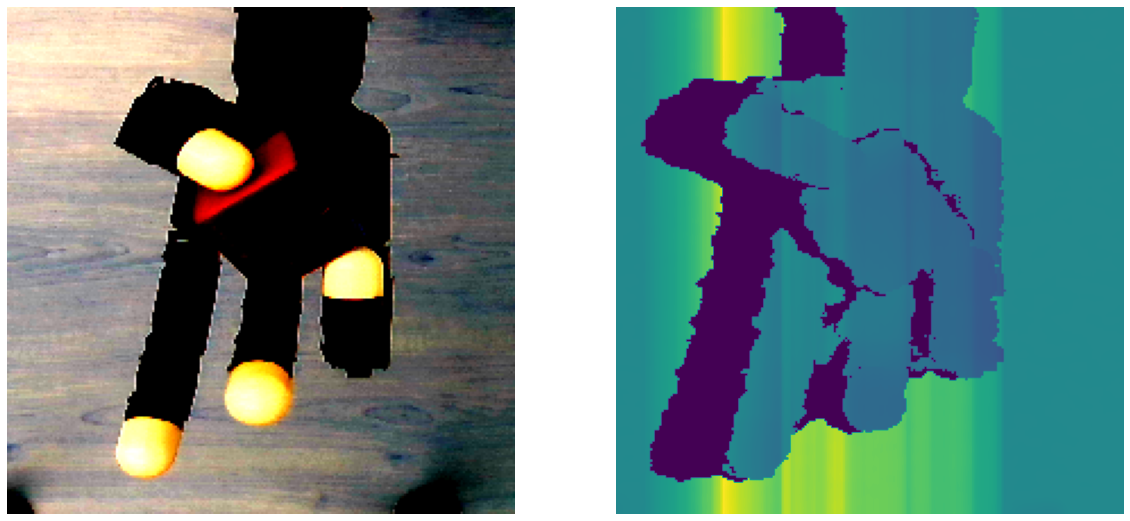

In [12]:
# sample image and show
sample, Y = X_train[0]
sample = sample.permute(1,2,0)

figure = plt.figure(figsize=(20, 10))
figure.add_subplot(1, 2, 1)
plt.imshow(sample[:,:,0:3])
plt.axis("off")  

figure.add_subplot(1, 2, 2)
plt.imshow(sample[:,:,3])
plt.axis("off")  
plt.show()

## Defining the Convolutional Neural Network

 ## Convolutional Neural Network

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        # convolution layers
        self.conv_1 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=2, stride=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv_2 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=3)
        
        # fc layers
        self.linear_1 = nn.Linear(1944, 24)
        self.linear_2 = nn.Linear(24, 12)
        
    def conv(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x
    
    def fc(self, x):
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        return x
    
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        x = x.to(torch.float64)
        return x

## Training and Testing the Model

In [14]:
model = NeuralNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    model.train()
    
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # forward pass
        optimizer.zero_grad()
        output = model.forward(X)
        
        # backpropogation
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        if batch % 10 == 0:
            loss, current = math.sqrt(loss.item()), min(batch * 64, size)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:5>d}]")

In [16]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------------------")
    train(train_loader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
--------------------------------
loss: 0.179367 [    0/3396]
loss: 0.145746 [  640/3396]
loss: 0.132151 [ 1280/3396]
loss: 0.124083 [ 1920/3396]
loss: 0.120404 [ 2560/3396]
loss: 0.117283 [ 3200/3396]
Epoch 2
--------------------------------
loss: 0.115578 [    0/3396]
loss: 0.112121 [  640/3396]
loss: 0.112966 [ 1280/3396]
loss: 0.108576 [ 1920/3396]
loss: 0.106532 [ 2560/3396]
loss: 0.106626 [ 3200/3396]
Epoch 3
--------------------------------
loss: 0.104408 [    0/3396]
loss: 0.105452 [  640/3396]
loss: 0.101938 [ 1280/3396]
loss: 0.101192 [ 1920/3396]
loss: 0.100007 [ 2560/3396]
loss: 0.098104 [ 3200/3396]
Epoch 4
--------------------------------
loss: 0.098229 [    0/3396]
loss: 0.095791 [  640/3396]
loss: 0.095737 [ 1280/3396]
loss: 0.096222 [ 1920/3396]
loss: 0.093160 [ 2560/3396]
loss: 0.092739 [ 3200/3396]
Epoch 5
--------------------------------
loss: 0.092075 [    0/3396]
loss: 0.091000 [  640/3396]
loss: 0.090266 [ 1280/3396]
loss: 0.086016 [ 1920/3396]
loss: 0.088

## Run and write test output to CSV file

In [17]:
import pickle
import pandas as pd

outfile = 'submission.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
preds = []


file_ids = torch.load("/kaggle/input/csci-ua-473-intro-to-machine-learning-fall-2022/test/test/testX.pt")[-1]

X_test = LazyLoadDataset("./lazydata/", train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=64, shuffle=False)

model.eval()
for i, x in enumerate(test_loader):
    for batch_entry in x:
        output = model.forward(batch_entry[None,:,:,:].to(device))
        preds.append(output.cpu().detach().numpy())

preds = np.array(preds).squeeze()

df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file submission.csv
